In [110]:
import sys
#!{sys.executable} -m pip install fastai albumentations
#!{sys.executable} -m pip uninstall -y opencv-python-headless
#!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip list

Package                       Version
----------------------------- ---------
aiohttp                       3.8.1
aiosignal                     1.2.0
albumentations                1.1.0
anyio                         3.5.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
async-timeout                 4.0.2
asynctest                     0.13.0
attrs                         20.3.0
autovizwidget                 0.19.1
awscli                        1.22.97
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
bcrypt                        3.2.0
beautifulsoup4                4.10.0
bleach                        4.1.0
blis                          0.7.7
bokeh                         2.4.2
boto3                         1.21.42
botocore                      1.24.42
brotlipy                      0.7.0
cached-property               1.5.2
catalogue                     2.0.7
certifi                       2021.10.8
cffi  

In [111]:
import numpy as np
import pandas as pd
import os
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision.all import *

import fastai # https://docs.fast.ai/dev/abbr.html
print('The version of FastAI being used is:',fastai.__version__)
import cv2
print('The version of cv2 being used is:',cv2.__version__)


The version of FastAI being used is: 2.6.3
The version of cv2 being used is: 4.5.5


(208, 176)


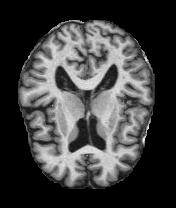

In [112]:
from PIL import Image
img =  Image.open('Alzheimer_s Dataset/train/VeryMildDemented/verymildDem972.jpg')
PATH = Path('Alzheimer_s Dataset/')
print(img.shape)
img

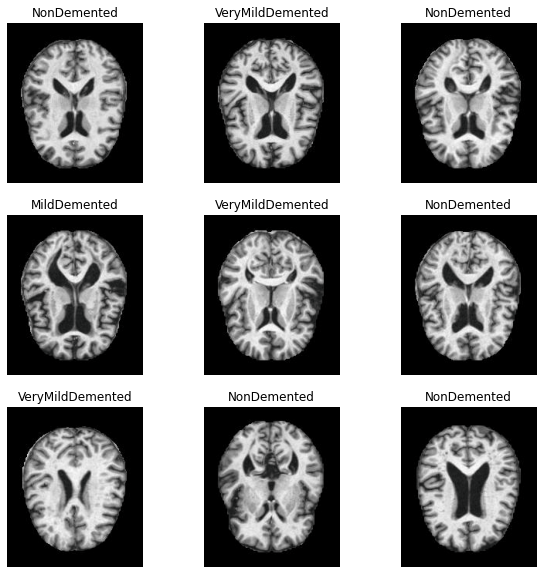

In [113]:
import albumentations as A

transform = A.Compose([
    A.Affine(rotate=7.5, scale=1.15),# max_rotate , max_zoom
    A.Sharpen(lightness=0.15, p=0.8), # max_lighting , p_lighting 
    A.Perspective( pad_val=0), # xtra_tfms.pad.mode
    A.CoarseDropout(max_holes=3,min_height=5,min_width=5,max_height=5,max_width=5), # cutout.n_holes , cutout.length(max_h_size,max_w_size)
   # xtra_tfms.symmetric_warp.magnitude
],p=0.8)# p_affine
data = ImageDataLoaders.from_folder('Alzheimer_s Dataset/',
                                    train="train/",
                                    valid_pct=.4,
                                    ds_tfms=transform,
                                    size=112,
                                    bs=64,
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))

data.show_batch(nrows=3, figsize=(10,10))

In [114]:
#Category.__eq__ = lambda self, that: self.data == that.data
#Category.__hash__ = lambda self: hash(self.obj)
#Counter(data.classes)

In [115]:
vgg16 = fastai.vision.models.vgg16_bn #https://pytorch.org/vision/stable/models.html
learn = vision_learner(data,vgg16,metrics=[FBeta(average='weighted',beta=0.1),accuracy],wd=1e-1)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,1.849219,1.024672,0.641131,0.611460,01:01
1,1.309835,0.803498,0.696017,0.695107,01:03
2,0.934505,0.730839,0.717846,0.717691,01:04
3,0.719008,0.694791,0.730301,0.732330,01:06


In [116]:
Model_Path = Path('model/')
learn.model_dir = Model_Path
learn.save('checkpoint-1')


Path('Alzheimer_s Dataset/model/checkpoint-1.pth')

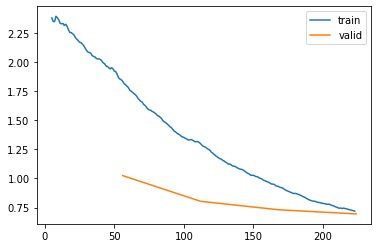

In [117]:
learn.model
learn.recorder.plot_loss()

In [118]:
learn.load('checkpoint-1')

In [119]:
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.612935,0.652159,0.736252,0.741949,01:32
1,0.518075,0.610824,0.756394,0.760351,01:33
2,0.374881,0.527219,0.799997,0.802175,01:32
3,0.255041,0.484585,0.817794,0.816395,01:32
4,0.168801,0.483218,0.812637,0.813467,01:32
5,0.132348,0.481070,0.820326,0.819741,01:31


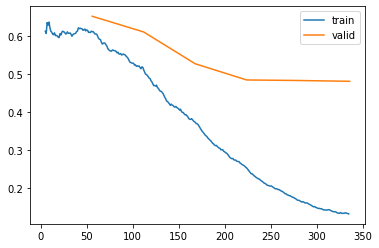

In [120]:
learn.model
learn.recorder.plot_loss()


In [121]:
learn.save('checkpoint-2')

Path('Alzheimer_s Dataset/model/checkpoint-2.pth')

In [122]:
#from torch import distributed
#learn.destroy_process_group()

In [123]:
transform = A.Compose([
    A.Affine(rotate=7.5, scale=1.15),# max_rotate , max_zoom
    A.Sharpen(lightness=0.15, p=0.8), # max_lighting , p_lighting 
    A.Perspective( pad_val=0), # xtra_tfms.pad.mode
    A.CoarseDropout(max_holes=6,min_height=5,min_width=5,max_height=20,max_width=20), # cutout.n_holes , cutout.length(max_h_size,max_w_size)                           
    # max_warp=0.15,
    # xtra_tfms.symmetric_warp.magnitude
],p=0.8)# p_affine

In [124]:
data = ImageDataLoaders.from_folder('Alzheimer_s Dataset/',
                                    train="train/",
                                    valid_pct=.2,
                                    ds_tfms=transform,
                                    size=224,
                                    bs=32,
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))

SuggestedLRs(valley=0.0003981071640737355)

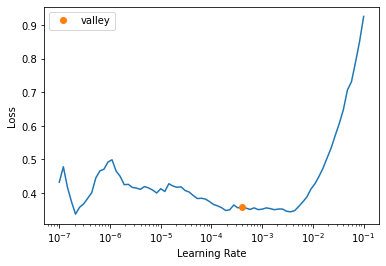

In [125]:
learn = vision_learner(data,vgg16,metrics=[FBeta(average='weighted',beta=0.1),error_rate],wd=1e-1)
Model_Path = Path('model/')
learn.model_dir = Model_Path
learn.load('checkpoint-2');
learn.lr_find()

In [126]:
#learn.recorder.plot_loss()

In [127]:
#learn.fit_one_cycle(200, lr_max=5e-4)
learn.fit_one_cycle(6, lr_max=5e-4)

epoch,train_loss,valid_loss,fbeta_score,error_rate,time
0,0.364478,0.194617,0.930734,0.069456,01:16
1,0.376581,0.203463,0.927261,0.072803,01:16
2,0.283685,0.192154,0.938243,0.061925,01:16
3,0.214834,0.179425,0.944645,0.055230,01:16
4,0.170401,0.182924,0.940739,0.059414,01:16
5,0.153820,0.183987,0.941722,0.058577,01:16


In [128]:
learn.save('checkpoint-3')



Path('Alzheimer_s Dataset/model/checkpoint-3.pth')

In [129]:
import torch
torch.save(learn.model.state_dict(), 'checkpoint-4.pth')
learn.export('trained_model-4.pkl')



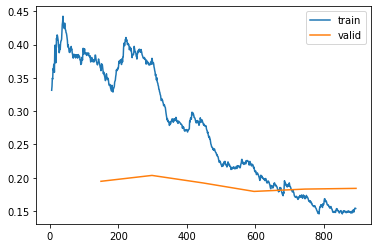

In [130]:
learn.model
learn.recorder.plot_loss()


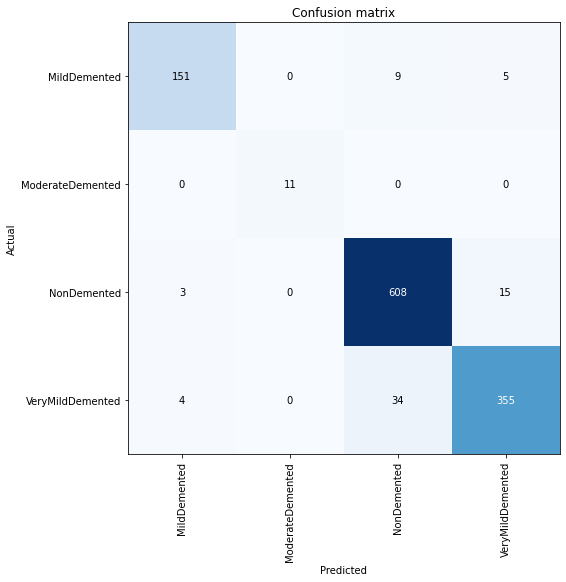

In [131]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(8,8))

In [132]:
transform = A.Compose([])

In [133]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
random_seed(42, True)

In [134]:
data_test = ImageDataLoaders.from_folder('Alzheimer_s Dataset/',
                                train="train/",
                                valid="test/",
                                valid_pct=.95,
                                size=224,
                                bs=32,
                                num_workers=0,
                                batch_tfms=Normalize.from_stats(*imagenet_stats))


#ev = learn.validate(data_test,metrics=[error_rate, FBeta(average='weighted',beta=0.1)])
#ev = learn.validate(dl=data_test)
ev = learn.validate()


print('Results from test set \tError rate:', float(ev[1]), '\tF Beta Score: ', float(ev[2]))

Results from test set 	Error rate: 0.9417219192360249 	F Beta Score:  0.05857740715146065


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


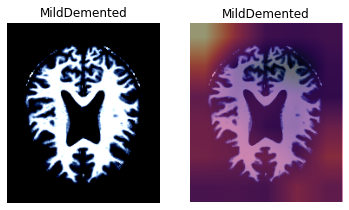

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


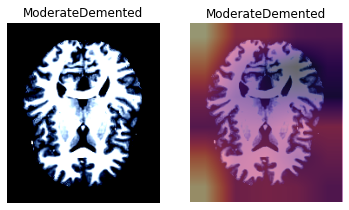

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


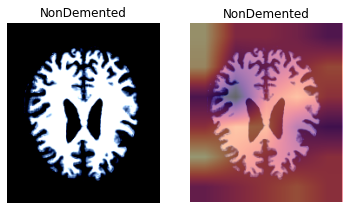

In [135]:
# The code below is slighty modified from https://www.kaggle.com/daisukelab/verifying-cnn-models-with-cam-and-etc-fast-ai
# and that code was a hevily modified version of https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb
#from fastai.callbacks.hooks import *


from fastai.test_utils import *

import torchvision.transforms as T

def visualize_cnn_by_cam(learn, data_index):
    
    #x, _y = learn.data.valid_ds[data_index]
    x, _y= learn.dls.valid_ds[data_index]
    

    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        
        #y = np.eye(learn.data.valid_ds.c)[y]         
        y =  np.eye(learn.dls.valid_ds.c)[y]    
        
    m = learn.model.eval()
    
    #xb,_ = learn.data.one_item(x)
    xb,_ = learn.dls.one_batch()
    
    #xb_im = Image(learn.data.denorm(xb)[0])
    transform = T.ToPILImage()
    #xb_im = transform(xb[0])# tensor image converted to pillow image
    xb_im = xb[0]# tensor image casted as pillow image
    
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)        
        img.show(axs[0])
        axs[1].set_title(label)
        img.show(axs[1])
        
        axs[1].imshow(hm,
                      alpha=0.6,
                      #extent=(0,img.shape[1],img.shape[1],0),
                      extent=(0,img.shape[1]*0.85,img.shape[1],0),
                      interpolation='bilinear',
                      cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        
        
        
        show_heatmap(img=xb_im, hm=mult,
                     #label=str(learn.data.valid_ds.y[data_index])
                     label=str(learn.dls.vocab[data_index])
                    )



#idx_list = [0,1,2,31,3,63, 142, 207]   
idx_list = [0,1,2]  
#idx_list = range(200,220)
for idx in idx_list:# range(10):
    visualize_cnn_by_cam(learn, idx)

In [136]:
learn.export('trained_vgg16_bn.pkl')


In [137]:
import tarfile
with tarfile.open('Alzheimer_s Dataset/trainedModel.tar.gz', 'w:gz') as f: 
    t = tarfile.TarInfo('models')
    t.type = tarfile.DIRTYPE
    f.addfile(t)
    f.add('Alzheimer_s Dataset/trained_vgg16_bn.pkl', arcname='trained_vgg16_bn.pkl')

In [138]:
import sagemaker
from sagemaker.utils import name_from_base
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = f'sagemaker/{name_from_base("fastai-alzheimer-model")}'
model_artefact = sagemaker_session.upload_data(path='Alzheimer_s Dataset/trainedModel.tar.gz', bucket=bucket, key_prefix=prefix)

In [139]:
from sagemaker.predictor import Predictor

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                         deserializer=json_deserializer, content_type='image/jpg')

In [140]:
role = sagemaker.get_execution_role()

In [141]:
from sagemaker.pytorch import PyTorchModel

model=PyTorchModel(model_data=model_artefact, name=name_from_base("fastai-alzheimer-model"),
    role=role, framework_version='1.0.0', py_version='py3', entry_point='serve.py', predictor_cls=ImagePredictor)

predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------

KeyboardInterrupt: 

In [ ]:
url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0a%0AHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCADQALABAREA/8QAHwAAAQUBAQEB%0AAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1Fh%0AByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZ%0AWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXG%0Ax8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+iiiiiiiiiiiiiiii%0AiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiinRxvLIqRqWZuABWvbeHLu%0AVVkk2xxHqfT2rpNJ8H2d26hd0zAjkH5f/r1o6j4RsrF1D2bEt/cQHH1qhceEtNKM8cWyLbjIlYOr%0AfQ5/lUekaHYmSSQ2sflqAMzfNkdzg8V2XhfwxYa3BL5qwugBAiZRgY6DFc1r/hO1M8q21iyRx9ZY%0AgFC/41x1xoE4kZbTNxgZ2ryenbHWsiiiiiiiiiiiirun6c965Y5WBT8z/wBB716t4d8F2EWkvchQ%0ATs5lP3vz7Vq+HtOgu7OSymXduY+XI3Perp8Paho7nyIDgdAB1rodJhXU4C11ZlJ1GGZhgVyvjK3t%0A45U+zKMsQGIrE/s/7BJb3ip5sEuAVJxivTNOsdI0yxTVVXZ8vzAHvWPql9ZajpdxHp8SJISdxPWu%0AY8EadZ3FzJbyALOGIbI5zWf4s8IWt7fS+XEftIPzMnBPT8+nevLdS02fTLowzqR/dbHDCqdFFFFF%0AFFFXdO0575yxysCH53x+g969j0DRNJis4vMjj8oKNo25P/667UaZb3HhiWHTJNzZO8AYIH0rmPDM%0AN3BrC2WPuNyfTmvRdd1m30S08+c7jwAvqaWzvZ9U0dri2hWORh8qnivMPFematGwmnxgHJCmqnh+%0AK913yYCP3CttAx1r1yHT7SzsIbG62eu1z1rh/Eo/sWe58u2Y7hldi8Gl8D6ZaGdLt5AkjncSf4j6%0AV1uq6TbRyPclVOQSa8z8V+H7TVIJAsYJxkEdR7j3rxvUtOn0y7aCYdPutjqKp0UUUUUVLbW0t3Os%0AMK7nb9PevafCnh6ymsYYYwjMq4G4ck+tT3dhd6TeOUBaFc70x0+ldB4I1xLjV2gUFVfhh0rrbTQI%0AdK1W41B5BjBYKewrzzVdch8ReLlgklAtICDz0JzXVS+NbLTrq3sLbyyoHzEelZPigWdxatdi9YRO%0Acsmc4q54V1TSdOso2iRTKBgHpWX4x14yGCVH/eiQD5T0HrXcaZHb63oSJcqJDjG89awZvBV3a3Pm%0A2dxhCdwC11txaySWkUEwDHAVsfzrltX0KWK3b7JGz7jycV5n4p8Jyy2UzOMzkbgHHAPbkV5LJG8M%0AjRyKVdTgg0yiiiiiu78DaWMG5lVj5nIBGAMZ5/LP516/oUOkTXESrI0Uo44XjNaviXR7hHW7hj3x%0AsMSY/nUXhfQVF99s2hNvPA71veJ5jBoU5Q5LfLk15Hp3g+S7unup5m2seFTgAfWr2t6PBbWQt7YK%0AJsgAr1zVGXw46WcMs11MVDBjuOQ3tW6+h/2hoolgO0x45Xgiudj0q8nupEvGDAD5Wz1r0PwLdiNZ%0ALCZyxUcV3CSYHIxgda5Dxp4wXQ7byVyJG/j715pN4x1qaJza280it1ZicVHNFr2paaXnkSJHByMc%0A/SvNNetGjeK4G0oy7GYf3gT1/DH5VjUUUUVJBC9xOkMalnc4AAr2fRr/AE2xt47WSB2kKfJGFxwB%0A2/Gt238VW2m4f+yWQZ+8Yye1ddovj7TNUcRS/IThcE/0NddCUjQCEIqPzkDrVO9sor61kt5OjDlj%0A2rhrvwtrUIcWsgaI/dweTVfRPDGpy6j5uqI3kqe9QeJtTFxA8Edq8flHaAF6+9bvgyO4azKThPKZ%0AcEAc5q/d+D7eeUzxuyYHAxVjRfDEWmzNP5jF27YxW2zqvAwM+1cR4y8Oy6tewy+Qzr3AHFVY/DrW%0AkJkvAI7dBnjqfauf1jUmvJV0+xhdI+hIHAH+Nc54n8KW0OlsiQ7ZSpbnPDY4NeTSRtFK8bjDoxVh%0AnPIptFFFaug280l+txEQBAcls8gkHH6/yr1Kw0GaK3i1CIM8ygBtxyOvI9q73RbG31XTw1xCY5FH%0APvTpfBcd4Fa3wGB4J4P512GkWj6Zp0VvPKZHXoauSMqyA8FduTk9KS2vbW7k8uOaJ2HBAPIqS+tL%0AprdhZkJL23dK8+8SW9+q7ryxKyL1liXIYe+Kf4YTUJIVkt4HSVhj5xgCvQbO1aG1AuX3SAc46VT/%0AALYs/tos0lBlA6DrTiWwq+UGycZ9KleNi21cAd8ms6/jsxEy3jgp0w3SuJ1PWdI0aXNvZK2TxIeR%0AmsfXNZgvIWuJFXhe1eB35B1G5IGAZXwPxNV6KKK6zwdNGkF9E4XdJLBhiOgG/P8ASvZLHWLTQ9Hk%0AnnCyFzna3TFbuneOtCmtwNqRFuo4rqtO1OwvlX7LInvir5QjBYgjtkVR1dZH0y58s4fyWwR9K+YE%0A17VdK1eSaC8ljlSU85PPPpXvvw7+IUfiiy+z3ZEd9EMP6P7iu8k+fqAVbqOxpB5Uf3NsYHYCuA+I%0AfxAj8NWbWlo6vfSL/wB8CvKfAviPUJvGkDyymQztzuOa+iQuEC8g9+aJXKQkrk4715f4ne41W8aI%0AzPHGD0U4xXN6joF1PalYrqQ46CQZFcnc2+sRQvCY5GRTg8ZFcbrsCwX6hV2lowze5yeazKKKK6Tw%0AeY2vJY5oy8bFOjYwwzj9M163BpFjfkG4usJzsjlO7aO1baeFNEnI23VuW6D5ea3tN8KRadIHjuSF%0AHZa6UzKu1A7GpmCtGEcE5BB5r5r+IehNo/iedhGRBId4P1rB0LWJ9D1eG+t2IaM5PPUV9N+G/FNp%0A4g0mK9RlQ7QHXPQ1S8Y+NbHw9pxkEqvO4wiA+3Wvm7VtTm1a/lurh2Jc569Pauz+EukPeeJ1vVBK%0AW/NfQUUu6QITyTnGKkZN4KsNoHGax7rQ7GWYSyRAZ6kcVSmfSbRGR1Q+2a53VZNLmtJDawhZPXPW%0AvAPGm3+3ztXaPLHH4mueooorrfBgt2t79ZcCUywiMkdPv5/SvSLPw1/aDhkuXJyAMNtBx7V3GleD%0AFheKe4lOFOdoOc1096JUjQWg9j7VnXesCwMcJIeRjyQM1qgs5Uufmxzg8GuM+I+jLqmkGQxDcq/e%0A96+e5IvKd0bhlOK6XwnrtzpN26RyERSLymeKo+IdXn1jUXeVvlHCjPSsdRv4wTk4r6D+GOkHS9D8%0AxkALqM9jzzXdQz7ZR8uSPSrvzbj0ArmvFE95HZEWakt/Ec5IFeSX+neIby5LLdxoP7vIqkkfiKzj%0AxIFlQckqc15hq9xNc6tcvO5ZhIyjPYAniqNFFFbvhW7aPU0syimK4dSxI5G3JGPzNey6Rps18qTW%0AdwVHGUJ6V6ZpdtcW1iiyN5rgZJzWVqviKaxlI+ysVB6gms2HWrPUL6Irb4kZgCT0rsHRQV4PA6VX%0A1G2ku9JljCEHbwc9RXzN4lszZ61PH0BbI96oaa+LoAnB5wajuSRO4J5z3q5otr9r1GCHHJbPB619%0AK+GIHj0kBshQBtBrWRV849h9a0A4I4JHfHrVNlBJ349wetc1e2mlRSM8hPynPFYfiKa1OkCSzChW%0AyAw61816i2/U7t/70zn/AMeNVqKKKu6RN9n1SCTuCQPqQQP1r3XwVrNpZW6tJOjkj7pOMV3Fr4z0%0A15lhE6KW7A1veVbXkOZUR1bkE4qIaFZRyJKlogOeCPWpZlImbGSB0GKjv5Gj0uUglWK9M4FfPPj+%0A2ZL6ObBO8fgDXK2gYXCHjrmn3rLLdOQAM9fY1teColk12Nm5CdPrX0ZoCB9J3iQ4JwV7A1eQDcdy%0A85/h71ZeTZGCoOKpXNwVhaRo2G0EkHnIrmf7S0zVbeYRsiNg8H1rzbxfey6ZaPbsrER7pYyp4zjo%0Aa8ZkcyyvI2MsSxx702iiiivWdI0mDVb9ssDCD8gjPDDOQQfxrvdJ8DWNti6kURKhzlmxXRr4m0u0%0AeO2V2ZU4z1rpbK9iu7dXgkV0bpjqKkcLlux/WsXxChOmGUFvlYD614v8QWQ28A3Ddu5rjdJs3vb9%0AY4lJC85B6VNrulz6deZkjO1xnIq/4JuBBryZYESDGDX0X4eRv7HIxg+ZyOxrUhUIxJHHr3rF1fxT%0AY2Ept2IklH8NUbXxNFdyFZo/LDfLk9D9ayNU8Ow7nvNPkCbuWCn+leP+Orq8tdyzuJTLlASOgINe%0AeUUUUUV6D4H8Rw6bYBZFOYHwQvXBJIP8xj2rrtQ8aXmswmO0inkDDAwMAVlafBrMF1++tJSWyd3U%0AV3XhNtZS5UOgWMkZCmvS2VioOTkDndVfUrdbjSnjZgTkYrwbxFpWoeIPFa6VaxFljOCQMge9eseG%0Avh7pegWCxyQ+ZcuBvkYdDWlqng3S9UtRHNbIMjAYCvHNY+HuoeHfEcVxbIXtvN3Zx0Ga9w0QFdKA%0AB7A4NXdrEnjt1rg9W8KNNqEs43FnJw2elc1qeka7po8yAJMmc4fj9ayp/E2s2UDrNpsgx3VsivM/%0AFep3OoXkHnMQBHu2e5J5/LFc/RRRRRWx4cuPK1NYXUNFL94fTJz/AD/OveNAksF8hFscrIBhvrXX%0AXMtlaED7GH9flrW00JJAJI4TGTyARV9juwoA/A0s8W+MKCFwecdaqQafY2UzzR26CVslpAvP51ym%0Ar+OXS6eKwQuI8g5HUjrUcfi7WLdYnvLVQjqrqgHO0nANdjvj1CzillACyKDgip7eGOJNq8r044xT%0A87dwbpjrmvNvEHiPW476WC3hJRTgEHANUtO1rVWYG6QcnpnOas+J/KGmCWJFSRkJzjuRXzdezfaL%0A6aXduDOcHGMjt+lQUUUUUVNa3DWl1HOnVD09R0I/KvdvA9xHFZxTPNkD7p68dsV1dx4902ykKSRL%0AIxwMN1P4V0eg61FrUHmCBoQDwD3ra8qPAbGDQXGc47VmalqVpZgLPIFLDGDxwa868R2tpaRNNayF%0AjJknB9al8ITRs0Ul9M0qhMAyHhQOgr0GDWbG5YQRurEDAArQjJER6D8OaRldonQNtZhgH0rznV9I%0A1y1d3ULKpJIPPNYL6jqcCZl0xsDujf41yPi/xg1zpc9ssMiblMTB+uSOn5ZP4V5hRRRRRRRXa+DP%0AETWkLWTopSP5gec4J5P4E/rXQR6hG2tSXCwCZiBhj2rs9E17ULe4iVZMgnlV+6Oeles20oMKPI3U%0AZNQTzqkUjod+0FvlryfX9bk1LUDIeCp24z0FUZrqCOJPtTbogQzoHwSOhA96VtQh+wSSWceIvm8p%0AC2cc8fXiovCmo302soZ8AB+Aor2sT/uiQeEXOPWuStfEeo/2jKSryQhiNmOgrautftoYUMxaMN2Z%0Aa5XXNbtbu1byJ0VFHPABNfOuvai2oarO25WjSRghXoRnrn3wKy6KKKKKKKmtLg2l3HOF3bTyvqOh%0AHtkZ5r0Xwnpa6tcCaO4YW7fcU/KT2wf5V6to3g9UCySzqFHOAc1rX3iPT7eF7SOQsV+UsOcVW8K6%0Awbi+msWkEikEg+lUPFPgy1ZpL1ThOrYJBH415Jq9o0c5VWeQIxUZbkjsfpVzRfDOq3kG3zZYVc8R%0AlcnHavUvBngo6WVmulO5SD83UmtrU/EdlaztADllOGAPQ1i3/iG3is3ezKLIQTkDpWZpfiO08QWb%0A2uoD96pxuxyK4Tx3cafpWmNaxKWkuNyxgccdyfpkV5XRRRRRRRRRWxoOv3OjT4jfbEzZPGcH1969%0A30HUZX0WSR7lcvGCpU5Bz0xXLxlP+El2O5Ksudua9B0HRotNu21NHC24TJ961P7RtPEllNbwT/OM%0AgA8ZrzvxHpIsASHMbocsR1I71r6R4jVdl3LKssuxVUkgYVRgCvQdM1BL3T1uBlQw9K8i8X20ltr3%0AmNI3lSMRJjp7U+10+1kVU+19cYBbrWd4iW20eB7qOYQTRfxDo31ryfVdVutYvPtV2+59u1cDGB1x%0A+pqlRRRRRRRRRRW5ovirUtFQQRSeZa84icZ2k9weo+nTk/Wur8JSrr2svdT3Y85RkRlsEDjnHpzX%0Ap+r6uY9Nj0uyO7C/M69zWPKv9lWAm88o2NxKnFYl94rttaskRnYzn5ORyfrVnSfDkMzxuZjtX1PF%0AdD4o11tE0eC3sJflTAZgepzWVNqDavoZSUrJIUyCTXlDay+m3wkgm810PG18r+dZeqave6xdNcXs%0A7SMTlVz8qeyjt0FUqKKKKKKKKKKKKkgnmtplmgleKVfuvGxVh26iugsvHOs2cYQvFcbcYaZSWAx6%0AgjP1PNXLrx5Pf2Bt7m2G8jG5SSB9Aelc/DrE9vcCaJE3DkBsmtW18b6raP8AuxEIyclAGx+HPFV9%0AT8V6hqZXzSAo/h7Vly6hdzQ+TJcSGLumcA/Ud6rUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU%0AUUUUUUUUUUUUUUV//9k='
img_bytes = requests.get(url).content
predictor.predict(img_bytes); response

('VeryMildDemented',
 TensorBase(3),
 TensorBase([5.9098e-04, 4.3578e-05, 2.1302e-07, 9.9937e-01]))

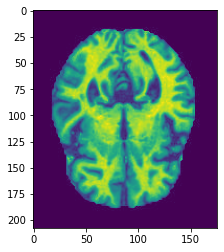

In [143]:
learn = load_learner('Alzheimer_s Dataset/trained_model-4.pkl')

def transform_image(image_bytes):
    image = Image.open(image_bytes)
    my_transforms = A.Compose([
               A.Affine(rotate=7.5, scale=1.15),# max_rotate , max_zoom
        A.Sharpen(lightness=0.15, p=0.8), # max_lighting , p_lighting 
        A.Perspective( pad_val=0), # xtra_tfms.pad.mode
        A.CoarseDropout(max_holes=6,min_height=5,min_width=5,max_height=20,max_width=20), # cutout.n_holes
    ], p=0.8)
    image2 = np.array(image)
    plt.imshow(image2)
    image_tensor1 = my_transforms(image = image2)['image']
    return image_tensor1

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    return learn.predict(tensor)

#TensorBase([0.0250, 0.0015, 0.5533, 0.4202])
get_prediction('imagenxd.jpeg')

In [144]:
learn.predict("imagenxd.jpeg")

('VeryMildDemented',
 TensorBase(3),
 TensorBase([0.0891, 0.0029, 0.2171, 0.6909]))

('VeryMildDemented',
 TensorBase(3),
 TensorBase([0.3931, 0.0050, 0.1872, 0.4148]))

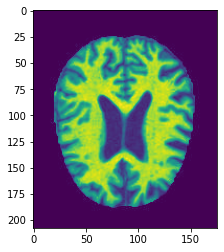

In [145]:
get_prediction('VeryMild.jpg')

In [146]:
learn.predict('VeryMild.jpg')

('VeryMildDemented',
 TensorBase(3),
 TensorBase([1.6667e-03, 1.8164e-04, 9.4374e-02, 9.0378e-01]))

In [147]:
import requests
resp = requests.post("http://127.0.0.1:5000/predict",files={"file": open('VeryMild.jpg','rb').read()})
print(resp.text)

ModerateDemented


In [148]:
import sys

!{sys.executable} -m pip freeze > requirements.txt